In [1]:
import torch
import numpy as np
from model import *
from helpers import *
from tqdm import tqdm
import torch.optim as optim 
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import math
import os 
import re
from itertools import repeat

mu = mu_p = -3
width = 50
x_data,y_data,dataset_name = generate_5pt_dataset(plot = False)
beta_1, beta_2 = cal_betas(mu,mu_p, width)
print(beta_1, beta_2) 
weight_savedir = "weight_recording"
error_savedir = "error_recording"
loss_savedir = "loss_recording"
savefolder = "ex_01_nokill"
random_seed = be_deterministic(True, random_seed=12)
config = f"{mu:.3f}_{mu_p:.3f}_w{width}_rs{random_seed}"
dataset_savefolder = os.path.join(savefolder)
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
parse_iter_id = -1
data_pt_aliases = 'ABCDE'
pic_savedir = 'pics'

8e-06 8e-06


In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
## we will require that the weights an d the errors are recorded under the same frequency.
weight_wholedir = os.path.join(savefolder, config, weight_savedir)
input_weights_paths = glob.glob(os.path.join(weight_wholedir,"*input.pt"))
output_weights_paths = glob.glob(os.path.join(weight_wholedir,"*output.pt"))
# order the sequence of the weight file path
def return_num_in_str(string, parse_num_id = parse_iter_id):
    return int(re.findall(r'\d+', string)[parse_num_id])
input_weights_paths = sorted(input_weights_paths, key = return_num_in_str)
output_weights_paths = sorted(output_weights_paths, key = return_num_in_str)
assert len(input_weights_paths)!=0

In [5]:
error_wholedir= os.path.join(savefolder, config, error_savedir)
errors_paths = glob.glob(os.path.join(error_wholedir,"*.pt"))
errors_paths = sorted(errors_paths, key = return_num_in_str)

In [6]:
sector_names = ["DE", "CDE", "BCDE", "ABCDE","ABCD", "ABC", "AB","A", "dead_sector", "E", "DE_2"]
sector_boundaries, sectors, sector_dict = derive_sectors(x_data, sector_names)
sectors

[Interval(0.0, 0.09966850280761719, closed='left'),
 Interval(0.09966850280761719, 0.5404195785522461, closed='left'),
 Interval(0.5404195785522461, 0.7853975296020508, closed='left'),
 Interval(0.7853975296020508, 2.530867099761963, closed='left'),
 Interval(2.530867099761963, 2.8501362800598145, closed='left'),
 Interval(2.8501362800598145, 3.2412610054016113, closed='left'),
 Interval(3.2412610054016113, 3.6820130348205566, closed='left'),
 Interval(3.6820130348205566, 3.9269909858703613, closed='left'),
 Interval(3.9269909858703613, 5.672459125518799, closed='left'),
 Interval(5.672459125518799, 5.99172830581665, closed='left'),
 Interval(5.99172830581665, 6.2831854820251465, closed='both')]

In [7]:
def calculate_d_one_open_sector( sector_name, x_data, error):
    activating_data_pts = re.findall('([A-Z])', sector_name)
    activating_data_pt_id_ls = [data_pt_aliases.index(letter) for letter in activating_data_pts]
    activating_data_pt_tensor = x_data[activating_data_pt_id_ls]
    corresponding_error = error[activating_data_pt_id_ls]
    d = torch.sum(corresponding_error * activating_data_pt_tensor, axis = 0)
    return d

In [8]:
def compute_angle_between_two_angles(angle1, angle2):
    """calculate the angle between two angles. The angle is chosen to be the smaller one between abs(angle1-angle2)
     and 2pi - abs(angle1-angle2)
    """
    angle_subtraction1 = torch.abs(angle1 - angle2).reshape(-1,1)
    angle_subtraction2 = (2*torch.pi - torch.abs(angle1 - angle2)).reshape(-1,1)
    angle_subtraction12 = torch.cat((angle_subtraction1, angle_subtraction2), dim = 1)
    angle_subtraction,_ = torch.min(angle_subtraction12, dim = 1)
    return angle_subtraction
    
    

In [9]:
def from_sector_name_to_color(sector_name, sector_names):
    """different sector, different color, always black for 'dead_sector'
    This function is not used
    """
    if "dead" in sector_name:
        return '#000000' #black
    else:
        sector_names_merged =[name.split('_')[0] for name in sector_names] ## one sector may be disconnected on (0,2pi), 
           # which means it mgiht be distributed at teh two ends of (0,2pi), like DE and DE_2, 
           # this operation make sure that they get the same color.
        sector_id = sector_names_merged.index(sector_name.split('_')[0])
        return px.colors.qualitative.Plotly[sector_id]
        

In [10]:
all_steps_dataframe = pd.DataFrame()
for input_weights_path, output_weights_path, errors_path in tqdm(zip(input_weights_paths, output_weights_paths, errors_paths),total = len(input_weights_paths)):
    iter_num = re.findall(r'\d+', input_weights_path)[-1]
    input_weight = torch.load(input_weights_path,map_location = device)
    output_weight = torch.load(output_weights_path, map_location = device).reshape(-1,1)
    error = torch.load(errors_path, map_location = device)
    ## use the error tensor to compute the d vector for each sector
    d_ls = []
    for sector_name in sector_names:
        d = calculate_d_one_open_sector(sector_name,x_data, error)
        d_ls.append(d) ## dead_sector's d is (0,0)
    d_dict = dict(zip(sector_names,d_ls))

    ## find out which open sectors actually have weights inside, and select out those d's corresponding to those sectors
    input_weight_zero_pos = (input_weight == torch.zeros(2)).any(axis = 1)
    output_weight_zero_pos = (output_weight == torch.zeros(1)).reshape(-1)
    overall_zero_pos = torch.logical_and(input_weight_zero_pos, output_weight_zero_pos) ## only weights with zero input and output weight at initialization time is guaranteed to have no effect on the system.
    ## are 1d tensors ↑
    nonzero_input_weight = input_weight[~overall_zero_pos]
    nonzero_output_weight = output_weight[~overall_zero_pos]
    nonzero_input_weight_ls = [tensor for tensor in nonzero_input_weight]
    nonzero_output_weight_ls = [tensor for tensor in nonzero_output_weight]
    nonzero_input_weight_id = (~overall_zero_pos).nonzero().squeeze(1)
    
    input_weight_norm = torch.linalg.norm(nonzero_input_weight, dim = 1) 
    
    input_weight_angle = np.arctan2(nonzero_input_weight[:,1], nonzero_input_weight[:,0])
    input_weight_angle = to_right_range(input_weight_angle)
    
    input_weight_sector = [in_which_sector(sectors, angle) for angle in input_weight_angle] ## a list of one-hot flags

    input_weight_sector_name = \
    np.asarray([(np.asarray(sector_names,dtype = object)[flag])[0] for flag in input_weight_sector],dtype='object')

    involved_d = [d_dict[active_sector] for active_sector in input_weight_sector_name]
    involved_d_tensor = torch.cat([d.unsqueeze(0) for d in involved_d ])
    involved_d_angle = to_right_range(np.arctan2(involved_d_tensor[:,1], involved_d_tensor[:,0]))
    involved_d_norm = torch.linalg.norm(involved_d_tensor,dim=1)
    d_compo1,d_compo2= involved_d_tensor[:,0], involved_d_tensor[:,1] # both are 1d tensors
    d_compo1_abs, d_compo2_abs = torch.abs(d_compo1), torch.abs(d_compo2)

    d_w_theta = compute_angle_between_two_angles(input_weight_angle, involved_d_angle)

    one_step_dataframe = pd.DataFrame(
        {   "iteration":[iter_num]*nonzero_input_weight_id.shape[0],
            "weight_id":nonzero_input_weight_id,
            "input_weight": nonzero_input_weight_ls,
            "output_weight": nonzero_output_weight_ls,
            "input_weight_angle": input_weight_angle,
            "input_weight_norm": input_weight_norm,
            "input_weight_sector_name": input_weight_sector_name,
            "d": involved_d,
            "d_angle": involved_d_angle,
            "d_norm": involved_d_norm,
            "d_compo1_abs":d_compo1_abs,
            "d_compo2_abs":d_compo2_abs, 
            "d_w_theta": d_w_theta
        }
    )
    
    all_steps_dataframe = all_steps_dataframe.append(one_step_dataframe)

all_steps_dataframe["weight_id"] = all_steps_dataframe["weight_id"].astype(str) ## better for visualization

100%|██████████| 300/300 [00:09<00:00, 31.49it/s]


In [11]:
critical_step_ls = np.array((42,152))*1000 

## Do some plots for the report

#### Angle Evolution Plot

In [12]:
all_steps_dataframe_new = all_steps_dataframe.copy()
all_steps_dataframe_new["iteration_num"] = all_steps_dataframe_new["iteration"].astype(int)

In [13]:
angle_time_df = all_steps_dataframe_new.pivot("iteration_num", "weight_id", "input_weight_angle")

In [14]:
iter_array = angle_time_df.index.values

In [15]:
final_angle = angle_time_df.iloc[-1]
group1_condition = (final_angle>2) & (final_angle<3)
group1_id_ls = np.asarray(final_angle[group1_condition].index,dtype = 'int')
group2_condition = (final_angle>0) & (final_angle<1)
group2_id_ls = np.asarray(final_angle[group2_condition].index,dtype = 'int')
group3_condition = (final_angle>5.7) 
group3_id_ls = np.asarray(final_angle[group3_condition].index,dtype = 'int')
group4_condition = (final_angle>3.6) & (final_angle<3.7)
group4_id_ls = np.asarray(final_angle[group4_condition].index,dtype = 'int')
dead_group_condition = (~group1_condition)&(~ group2_condition)&(~ group3_condition)&(~ group4_condition)
dead_group_id_ls = np.asarray(final_angle[dead_group_condition].index,dtype = 'int')

In [16]:
def get_color(id):
    if id in group1_id_ls: return 'r'
    if id in group2_id_ls: return 'y'
    if id in group3_id_ls: return 'g'
    if id in group4_id_ls: return 'b'
    if id in dead_group_id_ls: return 'k'

#### Generate four pictures together

C:\Users\ZHENGQ~1\AppData\Local\Temp/ipykernel_12164/2517639162.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(axs[2].get_yticks(),  )
C:\Users\ZHENGQ~1\AppData\Local\Temp/ipykernel_12164/2517639162.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_yticklabels(axs[2].get_yticks(),  )


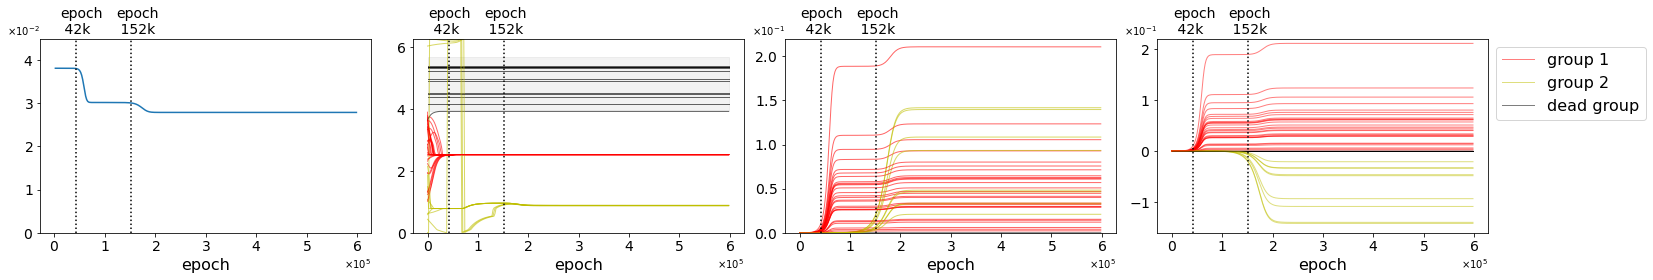

In [17]:
# Create a figure with 4 subplots in a row
fig, axs = plt.subplots(1, 4, figsize=(23, 4))  # 1 row, 4 columns
labelsize = 16
textsize = 14
ticksize = 14

# The loss plot
loss_dir = os.path.join(savefolder, config, loss_savedir, "loss.npz")
data = np.load(loss_dir)
loss_arr = data['loss_arr']
iter_arr = data['iter_arr']
axs[0].plot(iter_arr[1:], loss_arr[1:])
ylim_max = 0.045
axs[0].set_ylim([0,ylim_max])
for xc in critical_step_ls:
    axs[0].axvline(x=xc, color='k', linestyle=':')
    axs[0].text(xc-30000,ylim_max/44*45,f"epoch\n {int(xc/1000)}k",size=textsize)
axs[0].set_ylim([0, ylim_max])
axs[0].set_xlabel("epoch", fontsize=labelsize)
axs[0].xaxis.set_major_formatter(formatter1)
axs[0].set_yticklabels(axs[2].get_yticks(),  ) 
axs[0].yaxis.set_major_formatter(formatter)
axs[0].yaxis.get_offset_text().set_x(-0.1)
axs[0].tick_params(axis='both', which='major', labelsize=ticksize)


# Plot data on each subplot
group1_already = False
group2_already = False
group3_already = False
group4_already = False
dead_group_already = False
line_style = "-"
alpha = 0.6
linewidth = 1
for i in range(50):
    plot_data = angle_time_df[str(i)].values
    color = get_color(i)
    if color == 'r' and not group1_already:
        axs[1].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha, label = "group 1")
        group1_already = True
    elif color == 'y' and not group2_already:
        axs[1].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,label = "group 2")
        group2_already = True
    elif color == 'g' and not group3_already:
        axs[1].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,label = "group 3")
        group3_already = True
    elif color == 'b' and not group4_already:
        axs[1].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,label = "group 4")
        group4_already = True
    elif color == 'k' and not dead_group_already:
        axs[1].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,label = "dead group")
        dead_group_already = True
    else:
        axs[1].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,)
axs[1].set_xlabel('epoch', fontsize = labelsize)
axs[1].fill_between(iter_array, 3.9269909858703613, 5.672459125518799, color = "gray", alpha = 0.1)
axs[1].xaxis.set_major_formatter(formatter1)
ylim_max = 2*np.pi
axs[1].set_ylim([0,ylim_max])
for xc in critical_step_ls:
    axs[1].axvline(x=xc, color='k', linestyle=':')
    axs[1].text(xc-40000,ylim_max/44*45,f"epoch\n {int(xc/1000)}k", size=textsize)
axs[1].tick_params(axis='both', which='major', labelsize=ticksize)

# input norm plot
input_norm_time_df= all_steps_dataframe_new.pivot("iteration_num", "weight_id", "input_weight_norm")

group1_already = False
group2_already = False
group3_already = False
group4_already = False
dead_group_already = False
line_style = "-"
alpha = 0.6
linewidth = 1
for i in range(50):
    plot_data = input_norm_time_df[str(i)].values
    color = get_color(i)
    if color == 'r' and not group1_already:
        axs[2].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha, label = "group 1")
        group1_already = True
    elif color == 'y' and not group2_already:
        axs[2].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,label = "group 2")
        group2_already = True
    elif color == 'k' and not dead_group_already:
        axs[2].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,label = "dead group")
        dead_group_already = True
    else:
        axs[2].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,)
axs[2].set_xlabel('epoch',fontsize = labelsize)
axs[2].xaxis.set_major_formatter(formatter1)
axs[2].set_yticklabels(axs[2].get_yticks(),  ) 
axs[2].yaxis.set_major_formatter(formatter)
axs[2].yaxis.get_offset_text().set_x(-0.1)
ylim_max = 0.22
axs[2].set_ylim([0,ylim_max])
for xc in critical_step_ls:
    axs[2].axvline(x=xc, color='k', linestyle=':')
    axs[2].text(xc-40000,ylim_max/44*45,f"epoch\n {int(xc/1000)}k", size=textsize)
axs[2].tick_params(axis='both', which='major', labelsize=ticksize)

# output weight plot
output_weight_time_df= all_steps_dataframe_new.pivot("iteration_num", "weight_id", "output_weight")
group1_already = False
group2_already = False
group3_already = False
group4_already = False
dead_group_already = False
line_style = "-"
alpha = 0.5
linewidth = 1
for i in range(50):
    plot_data = output_weight_time_df[str(i)].values
    color = get_color(i)
    if color == 'r' and not group1_already:
        axs[3].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha, label = "group 1")
        group1_already = True
    elif color == 'y' and not group2_already:
        axs[3].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,label = "group 2")
        group2_already = True
    elif color == 'k' and not dead_group_already:
        axs[3].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,label = "dead group")
        dead_group_already = True
    else:
        axs[3].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,)
axs[3].set_xlabel('epoch', fontsize = labelsize)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
axs[3].xaxis.set_major_formatter(formatter1)
axs[3].yaxis.set_major_formatter(formatter)
axs[3].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=labelsize, bbox_to_anchor=(1., 1))
axs[3].yaxis.get_offset_text().set_x(-0.1)
# do the vertical line
ylim_min = -0.16
ylim_max = 0.22
axs[3].set_ylim([ylim_min, ylim_max])
for xc in critical_step_ls:
    axs[3].axvline(x=xc, color='k', linestyle=':')
    axs[3].text(xc-40000,ylim_min+(ylim_max-ylim_min)/44*45,f"epoch\n {int(xc/1000)}k", size=textsize)
axs[3].tick_params(axis='both', which='major', labelsize=ticksize)


plt.subplots_adjust(wspace=0.15)
plt.tight_layout()
plt.savefig(os.path.join(savefolder,config, "pics", "all_in_one_plot.png"),dpi=300)
